# Building and Training Convolutional Neural Networks (CNN) for Image Classification

This cell includes all the necessary import statements required to set up an environment for building and evaluating deep learning models using TensorFlow and related libraries:

### Libraries and Modules:
- **TensorFlow (`tf`)**: The core library for building and training machine learning models.
- **TensorFlow Datasets (`tfds`)**: Facilitates easy access to a wide range of datasets.
- **Matplotlib (`plt`)**: Used for creating visualizations such as training history plots and confusion matrices.
- **Keras Layers**: Includes layers like `Dropout`, `Dense`, `GlobalAveragePooling2D`, `MaxPooling2D`, `Conv2D`, `Flatten`, `Activation`
- **Keras Model**: Facilitates model creation and manipulation through classes like `Model` and `Sequential`.
- **Keras Regularizers**:  `l2` for L2 regularization
- **Scikit-learn Metrics**: Includes functions like `accuracy_score`, `precision_recall_fscore_support`, and `confusion_matrix` for evaluating model performance.
- **NumPy (`np`)** and **Pandas (`pd`)**: Essential for data manipulation and numerical operations.
- **Warnings**: Suppresses warnings to keep the notebook output clean and readable.

In [99]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Introduction

## Caltech101 Dataset Overview

- **Total Images**:  9,146 images.
- **Categories**: 101 object categories. Includes a wide range of categories from animals and vehicles to everyday objects and scenic views.
- **Dimensions**: Images vary in size, with typical dimensions around 300x200 pixels.
- **Distribution**: Each category contains about 40 to 800 images, though most categories have around 50 images.
- **Labels**: Each image is labeled with its respective category.

### Load the dataset

In [69]:
datasets, info = tfds.load(
    name='caltech101', 
    with_info=True,              
    as_supervised=True,        
    split=['train', 'test']     
)

This code loads the `caltech101` dataset from TensorFlow Datasets (tfds). It retrieves both the training and testing data in a supervised format (images paired with labels). The 'with_info' option is set to True to get additional details about the dataset, like the number of labels. The returned 'datasets' is a list containing the training and testing sets, and 'info' provides the dataset's metadata.

## Print some sample images from the training dataset.

2024-10-13 16:27:57.028508: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-13 16:27:57.034109: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


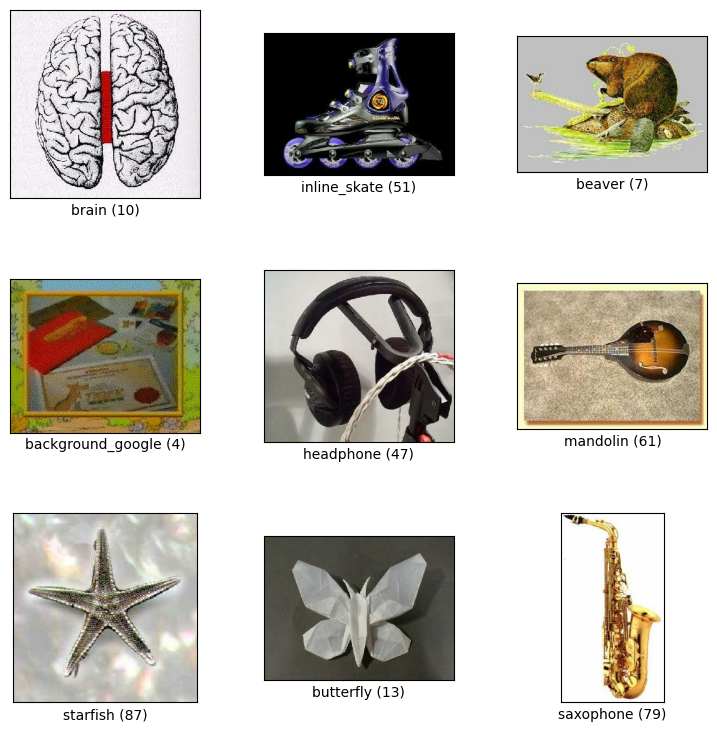

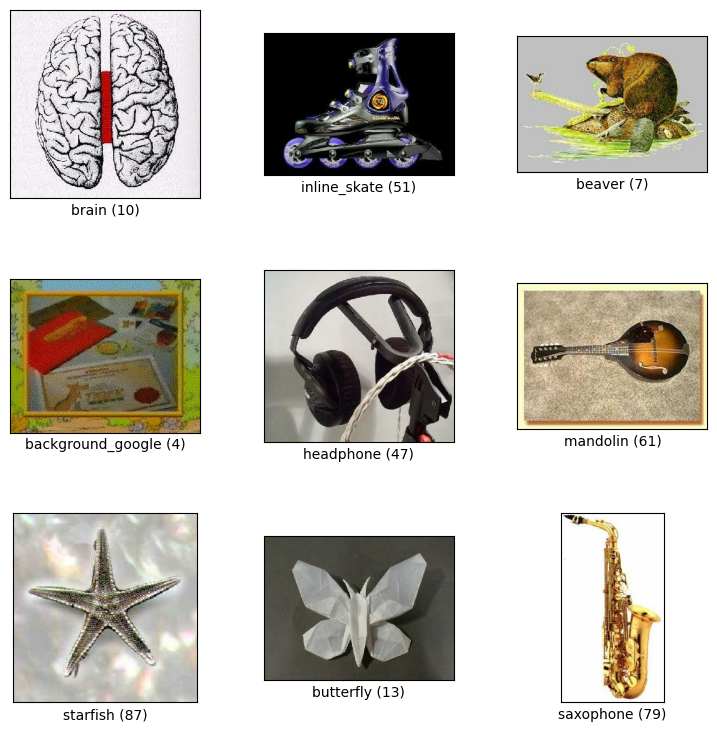

In [3]:
info_train,train = tfds.load(name='caltech101', with_info=True, split='train')
tfds.show_examples(info_train,train)

In [4]:
info

tfds.core.DatasetInfo(
    name='caltech101',
    full_name='caltech101/3.0.2',
    description="""
    Caltech-101 consists of pictures of objects belonging to 101 classes, plus one
    `background clutter` class. Each image is labelled with a single object. Each
    class contains roughly 40 to 800 images, totalling around 9k images. Images are
    of variable sizes, with typical edge lengths of 200-300 pixels. This version
    contains image-level labels only. The original dataset also contains bounding
    boxes.
    """,
    homepage='https://doi.org/10.22002/D1.20086',
    data_dir='/Users/annpetrosiann/tensorflow_datasets/caltech101/3.0.2',
    file_format=tfrecord,
    download_size=131.05 MiB,
    dataset_size=132.86 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=102),
    }),
    supervised_keys=('image', 'label'

# Concatenate the train and test datasets an shuffle

In [70]:
dataset=datasets[0].concatenate(datasets[1])
dataset=dataset.shuffle(3000)

#  Split the dataset into training, testing, and validation 

In [74]:
# Take the first 972 examples from the dataset for the validation set. This represents 10% of the dataset.
rsp_val = dataset.take(972)  

# Skip the first 972 examples used for validation, then take the next 972 examples for the test set. This also represents 10% of the dataset.
rsp_test = dataset.skip(972).take(972)  

# Skip the first 1944 examples (the sum of validation and test sets), then take the next 7200 examples for the training set. This accounts for the remaining 80% of the dataset.
rsp_train = dataset.skip(1944).take(7200)  


val_size = len(list(rsp_val))
print("Validation set size:", val_size)  
test_size = len(list(rsp_test))
print("Test set size:", test_size)       
train_size = len(list(rsp_train))
print("Training set size:", train_size)  

Validation set size: 972
Test set size: 972
Training set size: 7200


# Data Preprocessing

### Function: augmentation
This function performs data augmentation on an input image and its corresponding label. Data augmentation is a technique used to artificially expand the size of a dataset by generating modified versions of images in the dataset. The function applies the following transformations:

- **Random Flips**: The image is randomly flipped horizontally and vertically to simulate different orientations.
  
- **Random Rotations**: The image is randomly rotated by 0, 90, 180, or 270 degrees. This variation accounts for different rotational perspectives.

- **Random Brightness Adjustment**: The brightness of the image is randomly adjusted, increasing or decreasing it by up to 10%. This helps the model handle varying lighting conditions in new images.

- **Random Contrast Adjustment**: The contrast of the image is randomly adjusted within a specified range (0.8 to 1.2). This modification helps the model perform well across images with different contrast levels.

These transformations are applied while keeping the image's label unchanged, ensuring that the augmented image still corresponds to the correct label.


In [75]:
def augmentation(image, label):
   
    # Random flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random rotations
    image = tf.image.rot90(image, k=tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32))

    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness

    # Random contrast adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label


### Function: scale
This function prepares an image and its label for processing by a neural network. It performs two main tasks:

- **Normalization**: The pixel values of the image are converted to floating-point numbers and normalized to be within the range [0, 1].
- **Resizing**: The image is resized to 224x224 pixels, which is a common input size for convolutional neural networks. This standardization ensures that all images fed into the model have the same size, which is necessary for batch processing.
- **One-Hot Encoding**: The label is converted into a one-hot encoded vector with a length of 101, corresponding to the number of classes. One-hot encoding transforms categorical integer labels into a binary matrix representation.

In [76]:
def scale(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [224, 224]) 
    label = tf.one_hot(label, depth=101)   
    return image, label

## Augmentation visualization

To ensure that the augmentation function is working correctly and doesn't negatively affect the images, we will test it by visualizing the results.

2024-10-13 17:03:48.838585: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


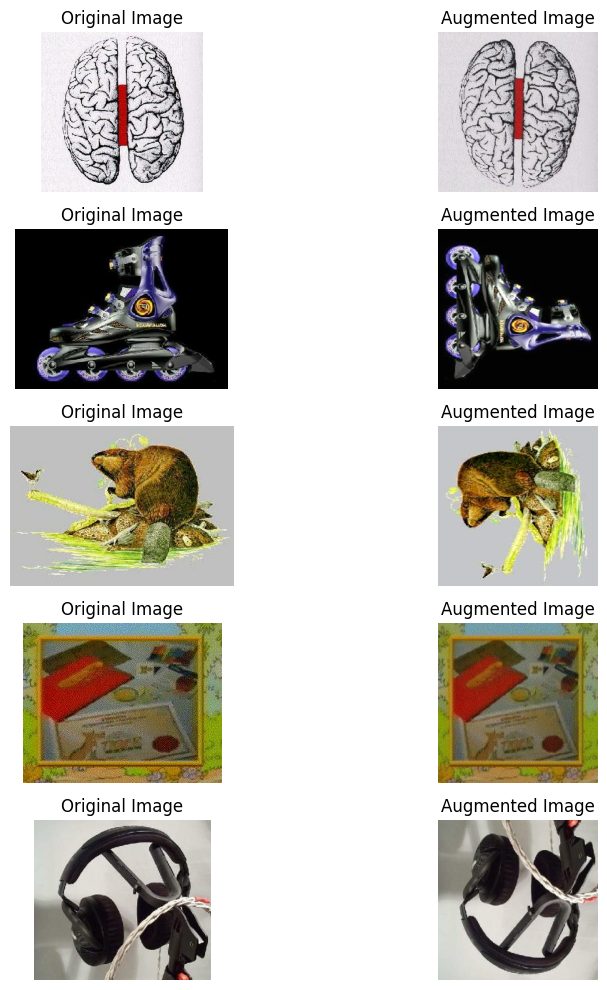

In [77]:
def visualize_preprocessing(dataset, num_images=5):
    plt.figure(figsize=(10, num_images * 2)) 
    for i, (image, label) in enumerate(dataset.take(num_images)):
        # Process the image
        processed_image, _ = scale(image, label)
        augmented_image, _ = augmentation(processed_image, label)
        
        # Plot original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.title("Original Image")
        plt.imshow(image.numpy().astype("uint8"))
        plt.axis("off")
        
        # Plot augmented image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.title("Augmented Image")
        plt.imshow(augmented_image.numpy())
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

datasets, info = tfds.load('caltech101', as_supervised=True, split=['train[:1%]'], with_info=True)
dataset = datasets[0]
visualize_preprocessing(dataset)

### Function: get_dataset
This function prepares and returns datasets for training, testing, and validation processes, ready for input into a neural network. Each dataset undergoes specific transformations to optimize them for the model:

- **Training Dataset**: The training dataset is first scaled and then augmented: Applies normalization and resizing through the `scale` function to each image. Further applies random transformations through the `augmentation` function to introduce variability, which helps prevent overfitting and enhances the model's ability to generalize. The scaled and augmented training images are shuffled with a buffer size close to the total number of training samples to ensure good randomization, then batched according to the specified batch size.

- **Testing Dataset**:
The testing dataset is only scaled (not augmented) to reflect real-world conditions where input data is not manipulated. Grouped into batches for evaluation processes.

- **Validation Dataset**:
Similarly to the testing dataset, the validation dataset is scaled for consistency in evaluation during model training. Prepared in batches for efficient validation steps during training iterations.

This function returns three datasets (training, testing, validation) that are ready for use in training and evaluating a neural network, ensuring that each dataset is appropriately preprocessed for optimal performance of the model.

In [78]:
def get_dataset(batch_size=64):
    train_dataset = rsp_train.map(scale, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(6000).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

   
    test_dataset = rsp_test.map(scale, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    
    val_dataset = rsp_val.map(scale, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, test_dataset, val_dataset

In [79]:
train_dataset, test_dataset, val_dataset = get_dataset()
train_dataset.cache()
val_dataset.cache()

<CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

## CNN Model Architecture

Initially, we trained a CNN with a more complex architecture, starting with 32 to 128 kernels, including dense layers with 512 units, dropout, and batch normalization. However, the training loss was extremely high and the accuracy extremely low. Therefore, we decided to simplify our model and trained it using the architecture mentioned below.


- **First Convolutional Layer**:
  - **Filters**: 16
  - **Kernel Size**: 3x3
  - **Padding**: 'same' (ensures the output size is the same as the input size)
  - **Input Shape**: 224x224 pixels with 3 color channels (RGB)
  - **Activation**: 'ReLU' 
  - **Max Pooling**: Pool size of 2x2 (reduces the spatial dimensions by half)

- **Second Convolutional Layer**:
  - **Filters**: 32
  - **Kernel Size**: 3x3
  - **Padding**: 'same'
  - **Activation**: 'ReLU'
  - **Max Pooling**: Pool size of 2x2

- **Third Convolutional Layer**:
  - **Filters**: 64
  - **Kernel Size**: 3x3
  - **Padding**: 'same'
  - **Activation**: 'ReLU'
  - **Max Pooling**: Pool size of 2x2

- **Flatten Layer**: Flattens the output of the previous layers into a 1D array to be used in the dense layers.

- **Fully Connected Layer**:
  - **Units**: 64
  - **Activation**: 'ReLU'
  - **Units**: 128
  - **Activation**: 'ReLU'
 
- **Output Layer**:
  - **Units**: 101 (corresponding to the number of classes in the dataset)
  - **Activation**: 'softmax' (used for multi-class classification to produce probabilities for each class)
  - 

In [87]:
model = Sequential([
    # First convolutional layer
    Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolutional layer
    Conv2D(32, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional layer
    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)), 

    # Flattening the convolutions
    Flatten(),
    
    # Fully connected layer
    Dense(64),
    Activation('relu'),
    
    # Fully connected layer
    Dense(128),
    Activation('relu'),
    
    # Output layer
    Dense(101), 
    Activation('softmax')
])

In [81]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 101)            │        13,029 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,256,261 (12.42 MB)

 Trainable params: 3,256,261 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

- **Optimizer**: 
Adam optimizer is chosen for its efficient computation and effective handling of sparse gradients on noisy problems. It combines the advantages of two other extensions of stochastic gradient descent: AdaGrad, which works well with sparse gradients, and RMSProp, which works well in online and non-stationary settings.

- **Loss Function**:
The Categorical Crossentropy loss is used for multi-class classification problems where an instance can only belong to one of many possible categories. 

- **Metrics**:
This metric calculates how often predictions match labels. It is used to monitor the training and testing steps to understand the model's performance, particularly, how often the model correctly classifies an image.


In [17]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [18]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()  # Call the base class constructor
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        self.model.reset_metrics() 

## Training Process

- **Epochs**:
An epoch is one complete presentation of the data set to be learned to a learning machine. Training the model for 6 epochs means that the entire dataset will pass through the CNN three times, allowing the model to adjust its weights and biases to minimize the loss.

- **Validation Data**:
  - **Usage**: The validation dataset is used to evaluate the model at the end of each epoch, providing insights into how well the model is generalizing to new data compared to its performance on the training data.

- **Callbacks**:
 This custom callback is used to record the statistics of training, such as loss and accuracy for each batch during the epochs. 

In [19]:
batch_stats_callback = CollectBatchStats()

history = model.fit(train_dataset, epochs=6, validation_data=val_dataset,
                    callbacks=[batch_stats_callback])

Epoch 1/6
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 390ms/step - accuracy: 0.2085 - loss: 3.7275 - val_accuracy: 0.1121 - val_loss: 4.3265
Epoch 2/6
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 354ms/step - accuracy: 0.3702 - loss: 2.8957 - val_accuracy: 0.1615 - val_loss: 3.8093
Epoch 3/6
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 339ms/step - accuracy: 0.4276 - loss: 2.4807 - val_accuracy: 0.1872 - val_loss: 3.6560
Epoch 4/6
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 337ms/step - accuracy: 0.4931 - loss: 2.1083 - val_accuracy: 0.1852 - val_loss: 3.8232
Epoch 5/6
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 339ms/step - accuracy: 0.5430 - loss: 1.8115 - val_accuracy: 0.2006 - val_loss: 3.8313
Epoch 6/6
113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 309ms/step - accuracy: 0.6118 - loss: 1.4723 - val_accuracy: 0.2233 - val_loss: 4.0809


As seen above, the model achieved an **accuracy of 0.6118** and a **loss of 1.4723** on training dataset.

## Custom functions

These custom functions are designed to be called after training the model to provide a comprehensive overview of the model's performance and training dynamics. <br>
`print_model_metrics` function calculates and prints various key performance metrics: accuracy, precision, recall, and F1 score. The function uses the weighted average method. <br>
`plot_training_metrics` function generates visualizations for the training process, specifically plotting the accuracy and loss over training steps. The graphs provide a visual insight into the learning progression of the model, helping to quickly identify trends such as improvements or potential issues like overfitting.

In [20]:
def print_model_metrics(y_true, y_pred):
    test_accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")

In [21]:
def plot_training_metrics(callback):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

    # Plot Accuracy
    axs[0].set_title('Training Accuracy')  
    axs[0].set_xlabel('Training Steps')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_ylim([0, 1])
    axs[0].plot(batch_stats_callback.batch_acc)
    
    # Plot Loss
    axs[1].set_title('Training Loss')  
    axs[1].set_xlabel('Training Steps')
    axs[1].set_ylabel('Loss')
    axs[1].set_ylim([0, 10])
    axs[1].plot(batch_stats_callback.batch_losses)
    
    plt.tight_layout()
    plt.show()

# Results 

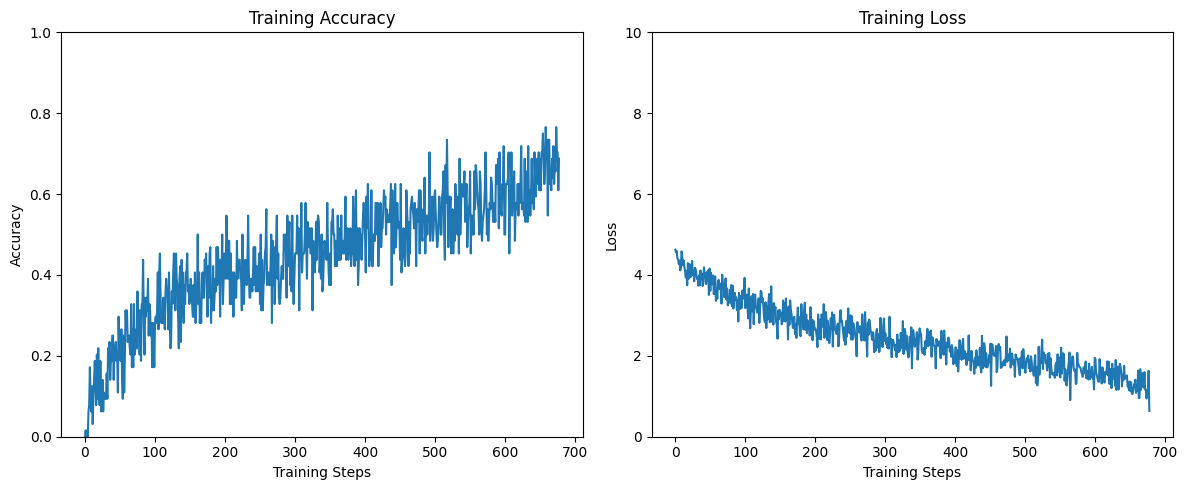

In [22]:
plot_training_metrics(batch_stats_callback)

`The accuracy graph` shows a positive trend, indicating that the model is learning and improving its ability to classify the training data correctly as training progresses. The accuracy starts from a lower value and gradually increases, which is typical for training dynamics.<br>
`The loss graph` shows a clear downward trend, indicating that the model is increasingly minimizing the error between the predicted and actual values, which aligns with the improving accuracy. The loss decreases sharply at first and then begins to level off, which is typical as the model starts to converge to a minimum in the loss landscape.

## Model Evaluation and Prediction

This custom function evaluates the model on the test dataset to get overall performance metrics and generates detailed
    predictions for further analysis.

In [23]:
def evaluate_and_predict(model, test_dataset):
    y_true = []
    y_pred = []
    
    evaluation_results = model.evaluate(test_dataset)
    
    for images, labels in test_dataset:
        
        predictions = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    return evaluation_results, y_true, y_pred

In [24]:
results, y_true, y_pred = evaluate_and_predict(model, test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.2918 - loss: 3.7845
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [25]:
print_model_metrics(y_true, y_pred)

Accuracy: 29.01%
Precision: 26.94%
Recall: 29.01%
F1 Score: 25.50%


The model shows good performance on the training data but poor results on the test set, indicating **difficulties in generalizing to unseen data**. As mentioned before, initially, the model was more complex, and simplifying it didn't lead to significant improvements. This points to possible underlying issues such as class imbalance. We should next examine the class distribution to determine if imbalance is affecting the model's performance and address this if necessary.

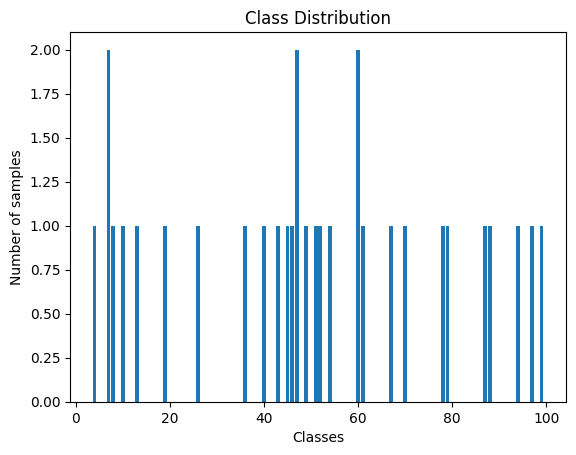

In [38]:
class_counts = {}

for image, label in dataset:
    label = label.numpy() 
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1


plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.show()

We can observe that three classes have significantly more samples than the others. Let's begin fine-tuning by setting a very low learning rate to enhance effective learning.

# Hyperparameter Tuning (Bonus)

## 1 - decreasing learning rate

In [88]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [89]:
batch_stats_callback = CollectBatchStats()

history = model.fit(train_dataset, epochs=3, validation_data=val_dataset,
                    callbacks=[batch_stats_callback])

Epoch 1/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 293ms/step - accuracy: 0.1154 - loss: 4.3416 - val_accuracy: 0.0422 - val_loss: 4.6600
Epoch 2/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 287ms/step - accuracy: 0.1720 - loss: 4.1544 - val_accuracy: 0.0514 - val_loss: 4.6956
Epoch 3/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 291ms/step - accuracy: 0.1953 - loss: 4.0353 - val_accuracy: 0.0679 - val_loss: 4.6799


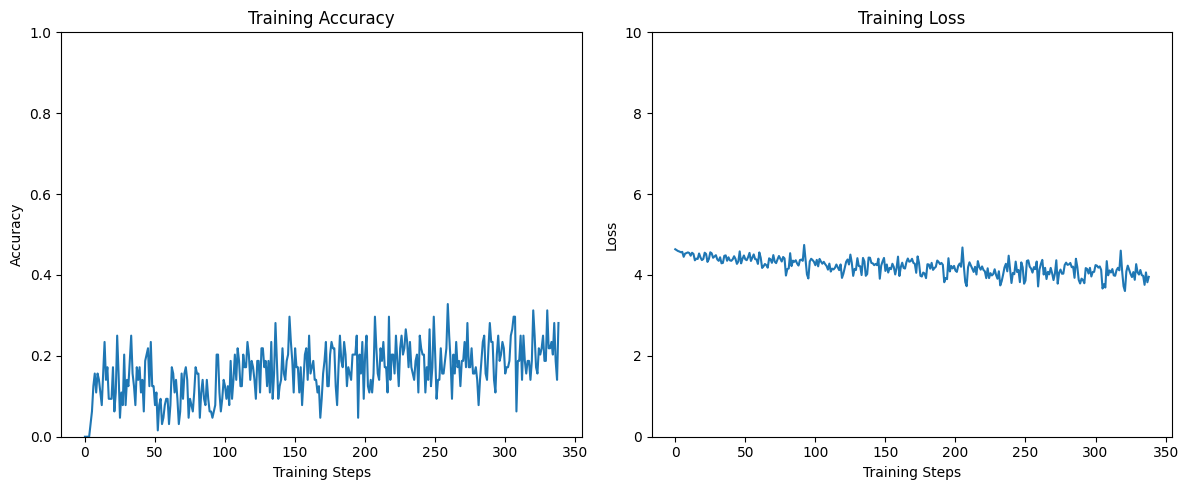

In [90]:
plot_training_metrics(batch_stats_callback)

In [91]:
results, y_true, y_pred = evaluate_and_predict(model, test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.1239 - loss: 4.4599
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [92]:
print_model_metrics(y_true, y_pred)

Accuracy: 13.27%
Precision: 2.69%
Recall: 13.27%
F1 Score: 4.37%


Even with a very low learning rate, the model's training process is still not stabilized. Therefore, we will try a different adaptive learning rate technique, such as RMSprop, which can help stabilize the training updates.

## 2- different optimizer

In [93]:
model.compile(
   optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.9),     loss=tf.keras.losses.CategoricalCrossentropy(),
   metrics=['accuracy']
)

In [94]:
batch_stats_callback = CollectBatchStats()

history = model.fit(train_dataset, epochs=5, validation_data=val_dataset,
                    callbacks=[batch_stats_callback])

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - accuracy: 0.0972 - loss: 4.4703 - val_accuracy: 0.0185 - val_loss: 4.9794
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 271ms/step - accuracy: 0.1580 - loss: 3.7892 - val_accuracy: 0.0617 - val_loss: 4.6374
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - accuracy: 0.1891 - loss: 3.6382 - val_accuracy: 0.0761 - val_loss: 4.4633
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 272ms/step - accuracy: 0.2812 - loss: 3.2660 - val_accuracy: 0.1070 - val_loss: 4.2658
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 266ms/step - accuracy: 0.3413 - loss: 2.9840 - val_accuracy: 0.1255 - val_loss: 4.3753


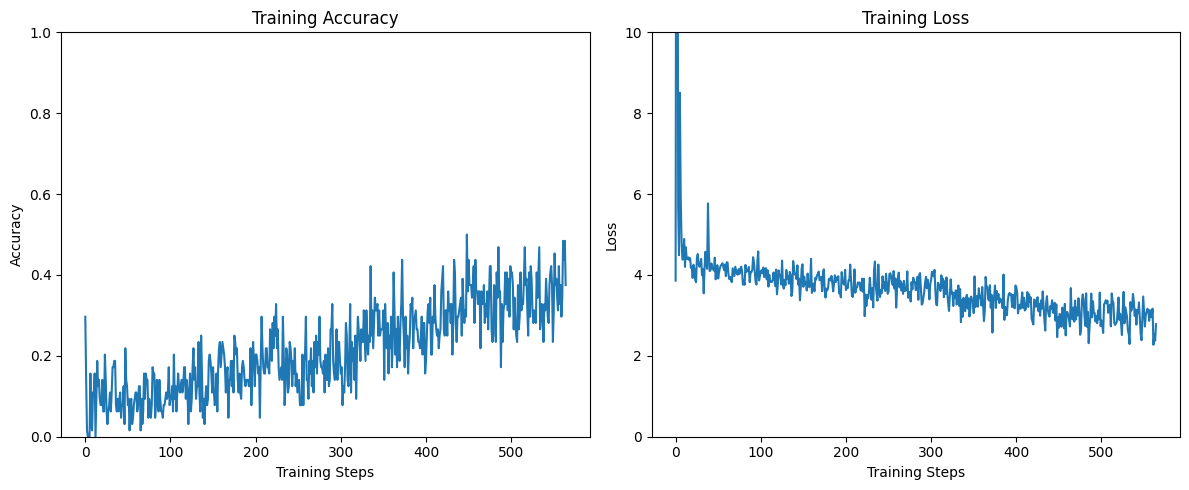

In [95]:
plot_training_metrics(batch_stats_callback)

The training accuracy and loss plots indicate that while the model's loss has generally stabilized, the accuracy remains relatively erratic and doesn't show a clear upward trend over the training steps. This suggests that the model may be experiencing high variance or isn't effectively learning from the training data, possibly due to overfitting or underfitting.<br>
To address this, we will now develop a new CNN model with regularization techniques such as dropout and L2 regularization to help improve model generalization and reduce overfitting.

In [96]:
results, y_true, y_pred = evaluate_and_predict(model, test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.1953 - loss: 3.9181
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [97]:
print_model_metrics(y_true, y_pred)

Accuracy: 21.71%
Precision: 13.37%
Recall: 21.71%
F1 Score: 14.00%


# 3 - different CNN with regularization

In [100]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), 
           kernel_regularizer=l2(0.001)),  # L2 regularization
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  
    Dense(101, activation='softmax') 
])

In [101]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 101)            │        13,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,181,989 (42.66 MB)

 Trainable params: 11,181,989 (42.66 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [103]:
batch_stats_callback = CollectBatchStats()

history = model.fit(train_dataset, epochs=5, validation_data=val_dataset,
                    callbacks=[batch_stats_callback])

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 634ms/step - accuracy: 0.1061 - loss: 4.4685 - val_accuracy: 0.0597 - val_loss: 4.6918
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 634ms/step - accuracy: 0.2045 - loss: 3.8658 - val_accuracy: 0.0751 - val_loss: 4.5543
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 631ms/step - accuracy: 0.2577 - loss: 3.5764 - val_accuracy: 0.0957 - val_loss: 4.4113
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 626ms/step - accuracy: 0.2899 - loss: 3.4049 - val_accuracy: 0.1132 - val_loss: 4.3611
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 632ms/step - accuracy: 0.3102 - loss: 3.2962 - val_accuracy: 0.1204 - val_loss: 4.2243


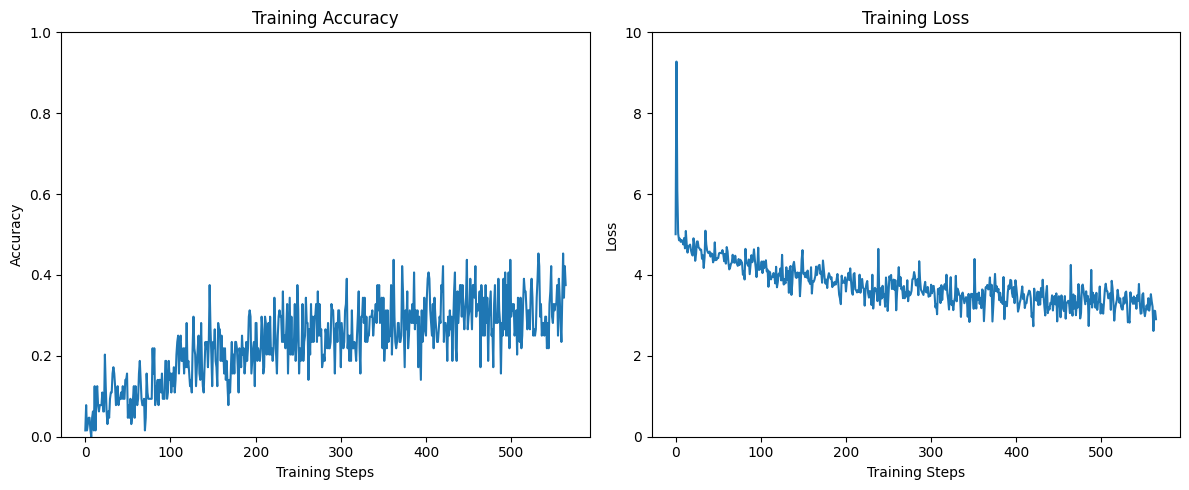

In [104]:
plot_training_metrics(batch_stats_callback)

In [105]:
results, y_true, y_pred = evaluate_and_predict(model, test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.1955 - loss: 3.8984
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [106]:
print_model_metrics(y_true, y_pred)

Accuracy: 22.33%
Precision: 10.25%
Recall: 22.33%
F1 Score: 12.46%


# Conclusion

| Metric    | Adam | Adam with Low LR | RMSprop | Adam with Regularization |
|-----------|------|------------------|---------|--------------------------|
| Accuracy  | 29.01% | 13.27%          | 21.71%  | 22.33%                   |
| Precision | 26.94% | 2.69%           | 13.37%  | 10.25%                   |
| Recall    | 29.01% | 13.27%          | 21.71%  | 22.33%                   |
| F1 Score  | 25.50% | 4.37%           | 14.00%  | 12.46%                   |


### What We Did
- **Model Complexity**:  
  We explored various model architectures, both complex and simplified, but observed no significant change in performance.

- **Data Quality**:  
  Data augmentation was thoroughly implemented and verified, presenting no issues. Additionally, the data was split using various methods, yet none led to noticeable improvements.

- **Hyperparameter Tuning**:  
  Several adjustments were made, including experimenting with different optimizers and lower learning rates. Additionally, we introduced overfitting countermeasures, such as L2 regularization and dropout. Despite these efforts, the desired improvements were not achieved.

### Future Suggestions
- **Class Imbalance**:  
  Our analysis identified that three classes significantly contribute to data imbalance. To address this in the future, we can consider implementing resampling techniques to balance the class distribution, either by undersampling the majority classes or oversampling the minority ones. Additionally, utilizing the Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic examples could further help equalize class distribution.

- **Advanced Techniques**:  
  Pre-trained models have proven to be highly effective. For instance, when we applied MobileNetV2 to our dataset, we achieved an impressive accuracy of 97%. Check on  [github page](https://github.com/annpetrosiann/deep_learning/blob/main/deep%20learning%202/task3/TL_version2.ipynb)